In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
import datetime

In [8]:
log_dir = "../logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
batch_size=32

path="../data/"
os.listdir(path)

['Fixated.csv', 'heart+disease', 'metadata.txt']

In [4]:
df=pd.read_csv(path+"fixated.csv")
labeltarget=["Tidak terdiagnosis", "terdiagnosis"]

In [33]:
#train test split
X=df.copy()
y=X.pop("target")
train_data, test_data, train_value, test_value = train_test_split(X, y, train_size= 0.8)

In [9]:
def thecallback():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]

def theplot(history):
    fig = plt.figure(figsize=(10,10))
    ax=fig.add_subplot(2,1,1)
    ax.plot(history.history["binary_accuracy"], label="binary_accuracy", c="blue")
    ax.plot(history.history["val_binary_accuracy"], label="val_binary_accuracy", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("accuracy")
    ax.legend(loc="lower right")
    ax=fig.add_subplot(2,1,2)
    ax.plot(history.history["loss"], label="loss", c="blue")
    ax.plot(history.history["val_loss"], label="val_loss", c="orange")
    ax.legend(loc="lower right")
    ax.set_ylim(0,1)
    ax.set_xlabel("epochs")
    ax.set_ylabel("losses")

In [16]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(16, activation='relu', input_dim=X.shape[1]),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), metrics=[keras.metrics.binary_accuracy])
  return model

In [17]:
epoch=100
test1=build_and_compile_model()
test1.fit(train_data, train_value, epochs=epoch, batch_size=batch_size,
          validation_data=(test_data, test_value),
          verbose=1, callbacks=thecallback())

Epoch 1/100
26/26 [==============================] - 1s 17ms/step - loss: 8.3674 - binary_accuracy: 0.5732 - val_loss: 3.6708 - val_binary_accuracy: 0.5951
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 3.0010 - binary_accuracy: 0.6463 - val_loss: 2.4625 - val_binary_accuracy: 0.5902
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 1.9741 - binary_accuracy: 0.6634 - val_loss: 1.8744 - val_binary_accuracy: 0.6341
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4959 - binary_accuracy: 0.6585 - val_loss: 1.5227 - val_binary_accuracy: 0.6195
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3028 - binary_accuracy: 0.6476 - val_loss: 1.1983 - val_binary_accuracy: 0.6244
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 1.0602 - binary_accuracy: 0.6695 - val_loss: 0.9448 - val_binary_accuracy: 0.6293
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - lo

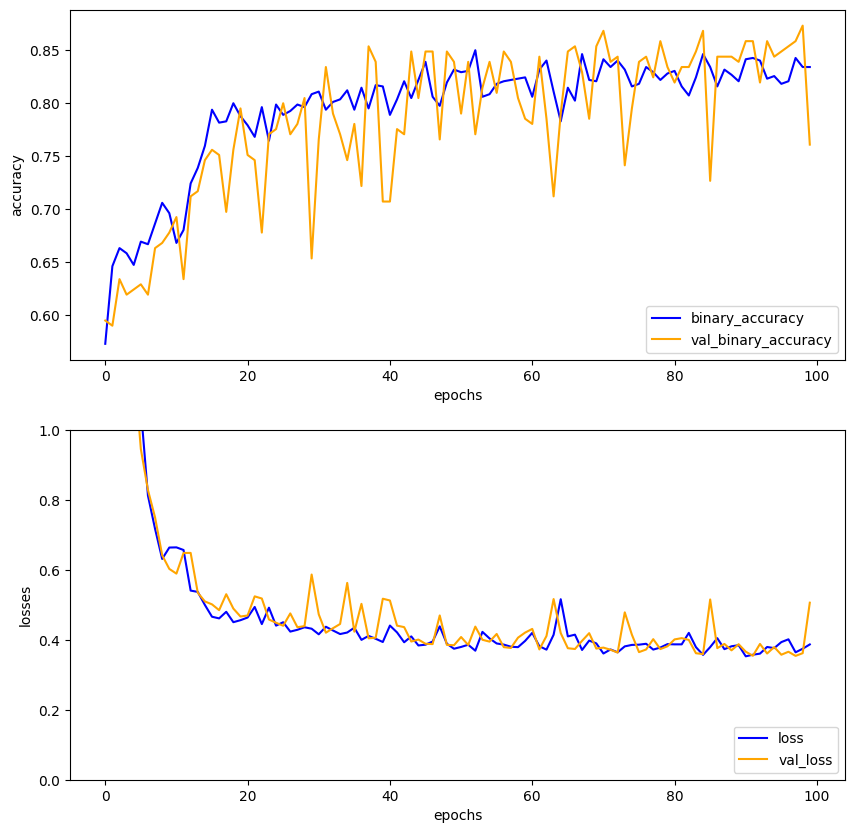

In [18]:
theplot(test1.history)

In [19]:
import keras_tuner as kt

#making the model

def getmodel(hp):
  model = keras.Sequential()
  
  #1st layer
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)            #Finding the best layer
  model.add(keras.layers.Dense(hp_units, activation='relu', input_dim=X.shape[1]))
  
  
  #output layer
  model.add(keras.layers.Dense(1, activation="sigmoid"))


  #learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  #Finding the best learning rate

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=["binary_accuracy"])

  return model

In [20]:
#Running the hyperparamatere search
thetuner=kt.Hyperband(getmodel, objective="val_binary_accuracy",                       #Finding the best val_accuracy of the brute!
                      max_epochs=30,
                      factor=2,
                      directory='Test1',  
                      project_name='test1')

In [21]:
thetuner.search(train_data, train_value, epochs=100, validation_data=(test_data, test_value))               #almost the same as keras.model.sequential.fit


best_hps=thetuner.get_best_hyperparameters(num_trials=1)

Trial 86 Complete [00h 00m 02s]
val_binary_accuracy: 0.8829268217086792

Best val_binary_accuracy So Far: 0.8829268217086792
Total elapsed time: 00h 02m 29s
INFO:tensorflow:Oracle triggered exit


In [34]:
#Built a model with the most optimal hyperparameters
model=thetuner.hypermodel.build(best_hps[0])

process=model.fit(train_data, train_value, epochs=1000, validation_data=(test_data, test_value))

Epoch 1/1000
26/26 [==============================] - 1s 8ms/step - loss: 1.4924 - binary_accuracy: 0.5488 - val_loss: 0.8606 - val_binary_accuracy: 0.5805
Epoch 2/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.5983 - binary_accuracy: 0.7110 - val_loss: 0.4764 - val_binary_accuracy: 0.7512
Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.4859 - binary_accuracy: 0.7439 - val_loss: 0.5650 - val_binary_accuracy: 0.7024
Epoch 4/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.4875 - binary_accuracy: 0.7585 - val_loss: 0.4489 - val_binary_accuracy: 0.7659
Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.4456 - binary_accuracy: 0.7890 - val_loss: 0.4524 - val_binary_accuracy: 0.7707
Epoch 6/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.4461 - binary_accuracy: 0.7841 - val_loss: 0.3867 - val_binary_accuracy: 0.8244
Epoch 7/1000
26/26 [==============================] - 0s 3ms/ste

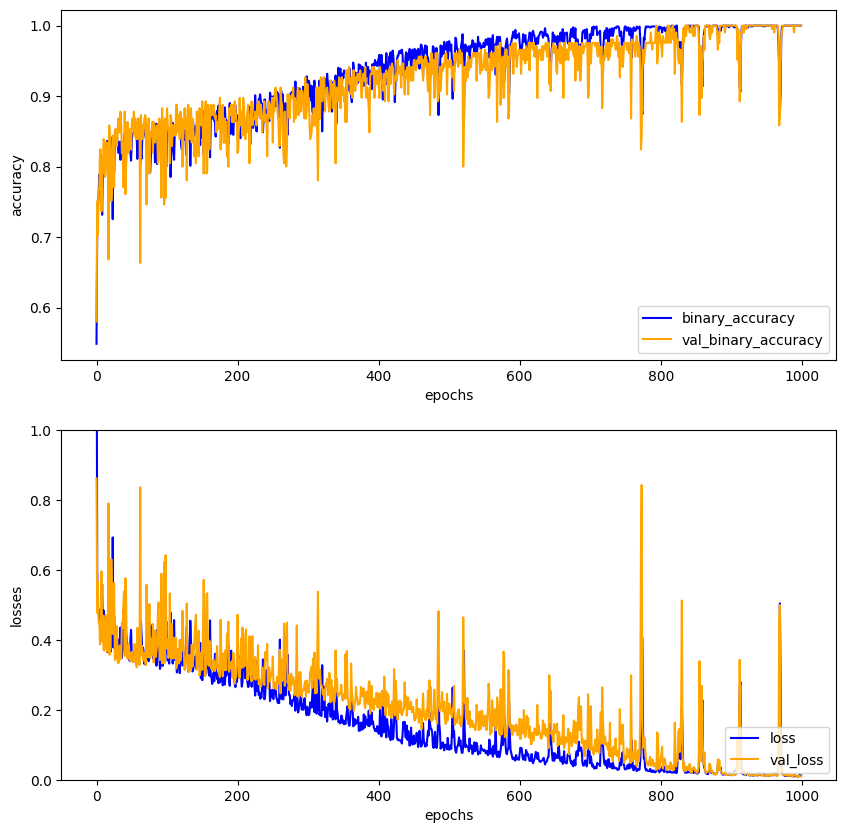

In [35]:
theplot(process)